# LTI ROM creation and simulation

This example shows how you can use PyAEDT to create a Linear Time Invariant (LTI) ROM in Twin Builder
and run a Twin Builder time-domain simulation. Inputs data are defined using Datapairs blocks with CSV files.

Keywords: **Twin Builder**, **LTI**, **ROM**.

## Perform imports and define constants

Perform required imports.

In [1]:
import datetime
import os
import subprocess
import tempfile
import time

import matplotlib.pyplot as plt
from ansys.aedt.core import TwinBuilder
from ansys.aedt.core.examples import downloads
from ansys.aedt.core.application.variables import CSVDataset

Define constants

In [2]:
AEDT_VERSION = "2025.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Set paths and define input files and variables

Set paths.

In [3]:
training_data_folder = "LTI_training_data.zip"
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")
input_dir = downloads.download_twin_builder_data(
    training_data_folder, True, temp_folder.name
)

Download data from example_data repository

In [4]:
twin_builder_data_folder = os.path.join(temp_folder.name, "twin_builder")
data_folder = os.path.join(twin_builder_data_folder, "LTI_training")

In [5]:
# Unzip training data and parse ports names
downloads.unzip(os.path.join(input_dir), data_folder)
ports_names_file = "Input_PortNames.txt"

C:\Users\ansys\AppData\Local\Temp\tmp94l1lt1b.ansys\twin_builder\LTI_training


## Get ports information from file

In [6]:
def get_ports_info(ports_file):
    with open(ports_file, "r") as PortNameFile:
        res = []
        line = PortNameFile.readline()
        line_list = list(line.split())
        for i in range(len(line_list)):
            res.append("Input" + str(i + 1) + "_" + line_list[i])

        line = PortNameFile.readline()
        line_list = list(line.split())
        for i in range(len(line_list)):
            res.append("Output" + str(i + 1) + "_" + line_list[i])
    return res

In [7]:
pin_names = get_ports_info(os.path.join(data_folder, ports_names_file))

## Launch Twin Builder

Launch Twin Builder using an implicit declaration and add a new design with
the default setup.

In [8]:
project_name = os.path.join(temp_folder.name, "LTI_ROM.aedt")
tb = TwinBuilder(
    project=project_name, version=AEDT_VERSION, non_graphical=NG_MODE, new_desktop=True
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_995905ee-82c2-4102-8bdb-23e766e47972.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 2456.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Project LTI_ROM has been created.


PyAEDT INFO: No design is present. Inserting a new design.


PyAEDT INFO: Added design 'Twin Builder_P7I' of type Twin Builder.


PyAEDT INFO: Aedt Objects correctly read


## Build the LTI ROM with specified configuration file

In [9]:
install_dir = tb.odesktop.GetRegistryString("Desktop/InstallationDirectory")
fitting_exe = os.path.join(install_dir, "FittingTool.exe")
path = '"' + fitting_exe + '"' + "  " + '"t"' + "  " + '"' + data_folder + '"'
process = subprocess.Popen(
    path, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE
)
tb.logger.info("Fitting the LTI ROM training data")
exec = True
startTime = datetime.datetime.now()
execTime = 0.0
while (
    exec and execTime < 60.0
):  # limiting the fitting process execution time to 1 minute
    out, err = process.communicate()
    execTime = (datetime.datetime.now() - startTime).total_seconds()
    if "An LTI ROM has been generated" in str(out):
        process.terminate()
        exec = False

PyAEDT INFO: Fitting the LTI ROM training data


In [10]:
rom_file = ""
model_name_sml = ""

In [11]:
for i in os.listdir(data_folder):
    if i.endswith(".sml"):
        model_name_sml = i.split(".")[0]
        rom_file = os.path.join(data_folder, i)

In [12]:
if os.path.exists(rom_file):
    tb.logger.info("Built intermediate ROM file successfully at: %s", rom_file)
else:
    tb.logger.info("ROM file does not exist at the expected location : %s", rom_file)

PyAEDT INFO: Built intermediate ROM file successfully at: C:\Users\ansys\AppData\Local\Temp\tmp94l1lt1b.ansys\twin_builder\LTI_training\Thermal_ROM_SML.sml


## Import the ROM component model

In [13]:
is_created = tb.modeler.schematic.create_component_from_sml(
    input_file=rom_file, model=model_name_sml, pins_names=pin_names
)
os.remove(rom_file)
tb.logger.info("LTI ROM model successfully imported.")

PyAEDT INFO: ModelerCircuit class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: ModelerTwinBuilder class has been initialized!


PyAEDT INFO: LTI ROM model successfully imported.


## Import the ROM component model in Twin Builder

Place components to create a schematic.

Define the grid distance for ease in calculations

In [14]:
grid_distance = 0.00254

Place the ROM component

In [15]:
rom1 = tb.modeler.schematic.create_component(
    "ROM1", "", model_name_sml, [36 * grid_distance, 28 * grid_distance]
)

Place datapairs blocks for inputs definition

In [16]:
source1 = tb.modeler.schematic.create_component(
    "source1",
    "",
    "Simplorer Elements\\Basic Elements\\Tools\\Time Functions:DATAPAIRS",
    [20 * grid_distance, 29 * grid_distance],
)
source2 = tb.modeler.schematic.create_component(
    "source2",
    "",
    "Simplorer Elements\\Basic Elements\\Tools\\Time Functions:DATAPAIRS",
    [20 * grid_distance, 25 * grid_distance],
)

Import Datasets

In [17]:
data1 = CSVDataset(os.path.join(data_folder, "data1.csv"))
data2 = CSVDataset(os.path.join(data_folder, "data2.csv"))
dataset1 = tb.create_dataset("data1", data1.data["time"], data1.data["input1"])
dataset2 = tb.create_dataset("data2", data2.data["time"], data2.data["input2"])

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmp94l1lt1b.ansys\LTI_ROM.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmp94l1lt1b.ansys\LTI_ROM.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015544652938842773


PyAEDT INFO: Dataset data1 doesn't exist.


PyAEDT INFO: Dataset $data1 created successfully.


PyAEDT INFO: Dataset data2 doesn't exist.


PyAEDT INFO: Dataset $data2 created successfully.


In [18]:
source1.parameters["CH_DATA"] = dataset1.name
source2.parameters["CH_DATA"] = dataset2.name

In [19]:
tb.modeler.schematic.update_quantity_value(source1.composed_name, "PERIO", "0")

True

In [20]:
tb.modeler.schematic.update_quantity_value(
    source1.composed_name, "TPERIO", "Tend+1", "s"
)

True

In [21]:
tb.modeler.schematic.update_quantity_value(source2.composed_name, "PERIO", "0")

True

In [22]:
tb.modeler.schematic.update_quantity_value(
    source2.composed_name, "TPERIO", "Tend+1", "s"
)

True

Connect components with wires

In [23]:
tb.modeler.schematic.create_wire(
    points=[source1.pins[0].location, rom1.pins[0].location]
)
tb.modeler.schematic.create_wire(
    points=[source2.pins[0].location, rom1.pins[1].location]
)

Class: ansys.aedt.core.modeler.circuits.object_3d_circuit.Wire

Zoom to fit the schematic

In [24]:
tb.modeler.zoom_to_fit()

## Parametrize transient setup

Parametrize the default transient setup by setting the end time and minimum/maximum time steps.

In [25]:
tb.set_end_time("700s")
tb.set_hmin("0.001s")
tb.set_hmax("1s")

True

## Solve transient setup

Solve the transient setup.

In [26]:
tb.analyze_setup("TR")

PyAEDT INFO: Solving design setup TR


PyAEDT INFO: Design setup TR solved correctly in 0.0h 0.0m 12.0s


True

## Get report data and plot using Matplotlib

Get report data and plot it using Matplotlib. The following code gets and plots
the values for the inputs and outputs of the LTI ROM.

Units used are based on AEDT default units.

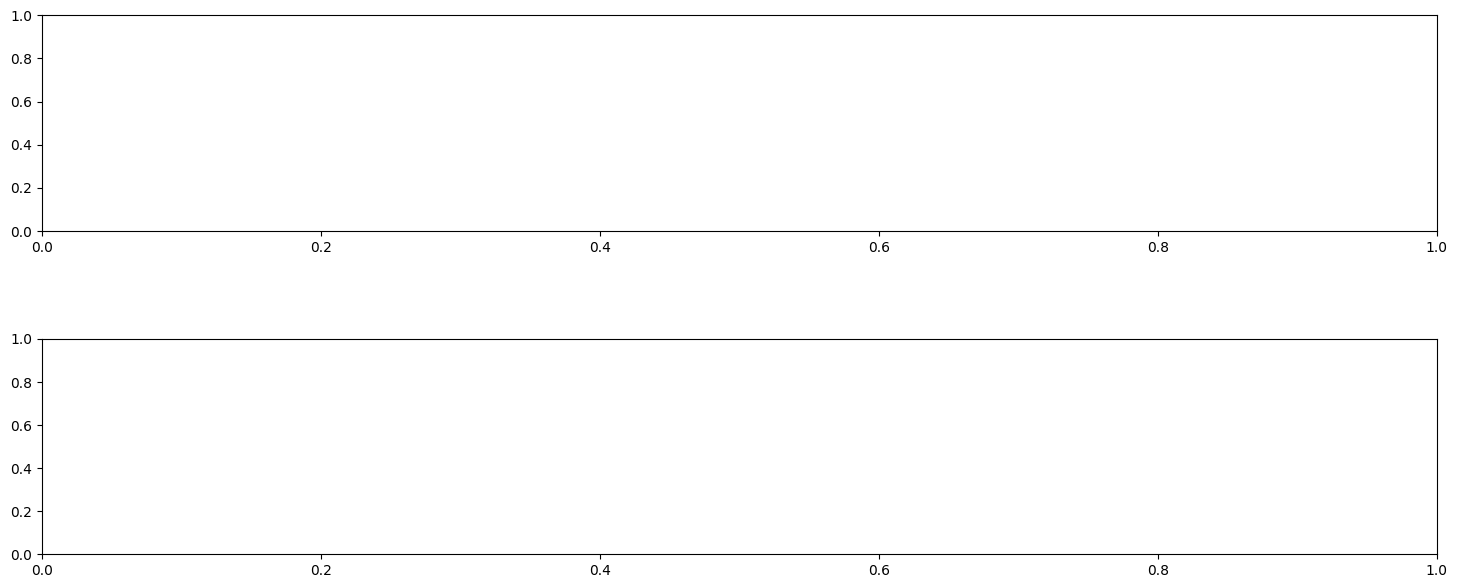

In [27]:
variables_postprocessing = []
pin_names_str = ",".join(pin_names)
rom_pins = pin_names_str.lower().split(",")
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(18, 7))
fig.subplots_adjust(hspace=0.5)

In [28]:
for i in range(0, 2):
    variable = "ROM1." + rom_pins[i]
    x = tb.post.get_solution_data(variable, "TR", "Time")
    ax[0].plot(
        [el for el in x.intrinsics["Time"]], x.data_real(variable), label=variable
    )

PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.0160369873046875
Time to initialize solution data:0.0160369873046875
PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.015666723251342773


Time to initialize solution data:0.015666723251342773


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ansys\aedt\core\visualization\post\solution_data.py:633: UserWarning: Method `data_real` is deprecated. Use :func:`get_expression_data` property instead.
  warnings.warn("Method `data_real` is deprecated. Use :func:`get_expression_data` property instead.")


In [29]:
ax[0].set_title("ROM inputs")
ax[0].legend(loc="upper left")

In [30]:
for i in range(2, 4):
    variable = "ROM1." + rom_pins[i]
    x = tb.post.get_solution_data(variable, "TR", "Time")
    ax[1].plot(
        [el for el in x.intrinsics["Time"]], x.data_real(variable), label=variable
    )

PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.015938758850097656


Time to initialize solution data:0.015938758850097656
PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.01613140106201172


Time to initialize solution data:0.01613140106201172


In [31]:
ax[1].set_title("ROM outputs")
ax[1].legend(loc="upper left")

Show plot

In [32]:
plt.show()

## Release AEDT

Release AEDT and close the example.

In [33]:
tb.save_project()
tb.release_desktop()

PyAEDT INFO: Project LTI_ROM Saved correctly


PyAEDT INFO: Desktop has been released and closed.


True

Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.

In [34]:
time.sleep(3)

## Clean up

All project files are saved in the folder ``temp_folder.name``. If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell removes all temporary files, including the project folder.

In [35]:
temp_folder.cleanup()